# Connect to Google Drive

reference: https://kgptalkie.com/human-activity-recognition-using-accelerometer-data/

Archived: https://web.archive.org/web/20210118012346/https://kgptalkie.com/human-activity-recognition-using-accelerometer-data/

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Imports

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, InputLayer
from tensorflow.keras.optimizers import Adam
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_validate
from sklearn.model_selection import LeaveOneGroupOut
import scipy.stats as stats
!pip install mlxtend==0.16.0
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Set Variables for Experiment

In [ ]:
model_name = 'basic_seq_model.h5'
classes = ['car', 'leisure', 'play', 'run_jog', 'seizure', 'sleep', 'walk']
frame_seconds = 4
hop_seconds = 4
Fs = 20
frame_size = Fs * frame_seconds 
hop_size = Fs * hop_seconds

# Load in Cleaned Dataset

In [ ]:
df = pd.read_csv(f'/content/drive/MyDrive/Smart Dog Collar/Data/03-31-2021_snapshot/cleaned_data.csv')
display(df)

,g_x,g_y,g_z,a_x,a_y,a_z,label
0,1.196273,-1.081498,1.421736,-0.073822,-1.294081,0.425378,6
1,0.395422,-0.997478,0.547428,0.546037,-0.524955,-1.332338,6
2,0.377894,0.056450,0.315224,-0.603559,1.311507,-1.984427,6
3,1.654736,-0.048575,0.936797,-0.858995,3.198385,-1.394055,6
4,0.961782,-1.176546,1.225371,-0.884146,4.978352,-1.363603,6
...,...,...,...,...,...,...,...
5561637,0.042518,-1.711649,0.272666,-0.014613,-0.025448,-0.020896,4
5561638,0.115358,-1.928526,0.314478,-0.014613,-0.025448,-0.020896,4
5561639,-0.130428,-1.877064,0.311491,-0.014613,-0.025448,-0.020896,4
5561640,-0.023700,-1.652310,0.274533,-0.014613,-0.025448,-0.020896,4


# Prepare the Data Frames


In [ ]:
def get_frames(df, frame_size, hop_size):

    N_FEATURES = df.iloc[:, :-1].shape[1]
    frames, labels = [], []

    for i in range(0, df.shape[0] - frame_size, hop_size):
        x = df['a_x'].values[i: i + frame_size]
        y = df['a_y'].values[i: i + frame_size]
        z = df['a_z'].values[i: i + frame_size]

        gx = df['g_x'].values[i: i + frame_size]
        gy = df['g_y'].values[i: i + frame_size]
        gz = df['g_z'].values[i: i + frame_size]

        # Retrieve the most often used label in this segment
        label = stats.mode(df['label'][i: i + frame_size])[0][0]
        frames.append([x, y, z, gx, gy, gz])
        labels.append(label)
        
    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)

    labels = np.asarray(labels)
    return frames, labels

In [ ]:
X, y = get_frames(df, frame_size, hop_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=0, 
                                                    stratify=y)
print('X train shape', X_train.shape)    
print('y train shape', y_train.shape)
print('X test shape', X_test.shape)    
print('y test shape', y_test.shape)

X train shape (55616, 80, 6)
y train shape (55616,)
X test shape (13904, 80, 6)
y test shape (13904,)


# Run Model

In [ ]:
num_classes = len(classes)
model = Sequential([
    InputLayer(input_shape=X_train[0].shape),
    Dense(300, activation='relu'),
    Dense(100, activation='relu'),
    Flatten(),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 80, 300)           2100      
_________________________________________________________________
dense_1 (Dense)              (None, 80, 100)           30100     
_________________________________________________________________
flatten (Flatten)            (None, 8000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 56007     
Total params: 88,207
Trainable params: 88,207
Non-trainable params: 0
_________________________________________________________________


In [ ]:
checkpoint = ModelCheckpoint(model_name, save_best_only=True)
early_stop = EarlyStopping(patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, validation_split=0.1, 
                    callbacks=[checkpoint, early_stop])

Epoch 1/100
1565/1565 [==============================] - 35s 22ms/step - loss: 0.5546 - accuracy: 0.8121 - val_loss: 0.4572 - val_accuracy: 0.8538
Epoch 2/100
1565/1565 [==============================] - 34s 22ms/step - loss: 0.3769 - accuracy: 0.8732 - val_loss: 0.3850 - val_accuracy: 0.8706
Epoch 3/100
1565/1565 [==============================] - 34s 22ms/step - loss: 0.3221 - accuracy: 0.8887 - val_loss: 0.3706 - val_accuracy: 0.8794
Epoch 4/100
1565/1565 [==============================] - 32s 21ms/step - loss: 0.2870 - accuracy: 0.9013 - val_loss: 0.3651 - val_accuracy: 0.8808
Epoch 5/100
1565/1565 [==============================] - 32s 21ms/step - loss: 0.2556 - accuracy: 0.9123 - val_loss: 0.3727 - val_accuracy: 0.8822
Epoch 6/100
1565/1565 [==============================] - 33s 21ms/step - loss: 0.2310 - accuracy: 0.9212 - val_loss: 0.3703 - val_accuracy: 0.8905
Epoch 7/100
1565/1565 [==============================] - 33s 21ms/step - loss: 0.2122 - accuracy: 0.9272 - val_loss: 0

First model, no dropout: 0.95/0.88, 0.13/0.58

# Model Loss and Accuracy

In [ ]:
def plot_stats(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

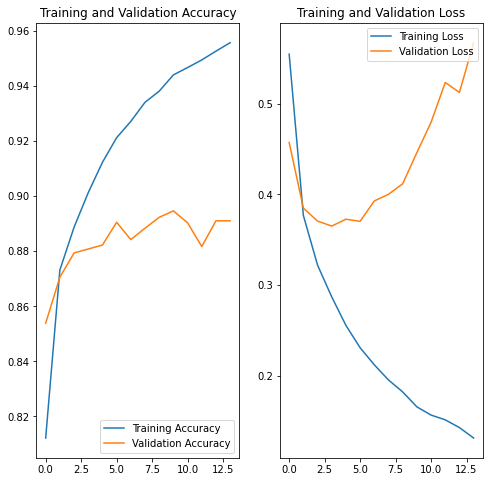

435/435 [==============================] - 16s 8ms/step - loss: 0.3577 - accuracy: 0.8823
Test Accuracy: 0.882


In [ ]:
# rollback to the best model
plot_stats(history, early_stop.stopped_epoch+1)
model = keras.models.load_model(model_name)
loss, acc = model.evaluate(X_test, y_test)
print("Test Accuracy: %.3f" % acc)

# Confusion Matrix

(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f89806b5750>)

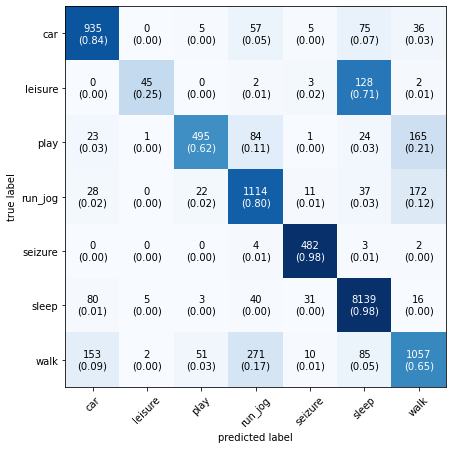

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=classes, show_normed=True, figsize=(7,7))

# Save the Model

In [ ]:
model.save(f'/content/drive/MyDrive/Smart Dog Collar/Models/{model_name}')